In [1]:
import pandas as pd
import numpy as np
import glob
import os
import json


## Feature Extract function

In [16]:
%%writefile preprocessing.py

from scipy.fftpack import fft
from scipy import signal
import numpy as np
import pandas as pd


def Calc_Time(signalData):
    Mean = np.mean(signalData) # 平均値
    Std = np.std(signalData - Mean)  #標準偏差

    return [Mean, Std]

# RMSを求める関数
def Calc_RMS(signalData):
    a = signalData * signalData  # 二乗
    sum_a = np.sum(a)  # 総和
    sqrt_a = np.sqrt(sum_a) # 平方根
    RMS = np.mean(sqrt_a) # 平均値
    
    return [RMS]

def Calc_Freq(signalData):
    L = len(signalData) # 信号長
    Win = signal.hann(L) #ハニング窓を使用

    S = np.fft.fft(Win * signalData) # 振幅スペクトル
    PowerSpectrum = (S * S.conjugate()) # パワースペクトル
    Energy = np.sum(PowerSpectrum.real)

    P = PowerSpectrum.real/np.sum(Energy)
    Entropy = -np.sum(P*np.log(P))


    return [Energy, Entropy]


Overwriting preprocessing.py


In [17]:
import preprocessing

In [18]:
save_folder = "../data/jikken1/"

feature_save_file = os.path.join(save_folder, "features.npy")
label_save_file = os.path.join(save_folder, "label.npy")
label_name_save_file = os.path.join(save_folder, "label_name.json")

kfold_split_save_file = os.path.join(save_folder, "kfold_train_val_test.npy")

In [19]:
features = np.load(feature_save_file, allow_pickle=True).astype(np.float)
labels = np.load(label_save_file, allow_pickle=True)

kfold_train_test_index_list = np.load(kfold_split_save_file, allow_pickle=True)

/var/folders/m8/y6jc4w1s4cbb3830x0n6zygr0000gn/T/ipykernel_73620/3045065398.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.load(feature_save_file, allow_pickle=True).astype(np.float)


In [89]:
with open(label_name_save_file) as f:
    label_list = json.load(f)
    
eng_label_dict = dict(zip(
    ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている'],
    ['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']
))
label_index_list= sorted(map(int, label_list.keys()))
eng_label_list = [eng_label_dict[label_list[str(i)]] for i in label_list_index]

In [88]:
label_list

{'0': '歩いている',
 '1': '立っている',
 '2': '走っている',
 '3': '階段降り',
 '4': '階段上り',
 '5': '座っている'}

In [21]:
feature_b, feature_ts, _ = features.shape
feature_b, feature_ts, _

(699, 200, 30)

In [25]:
columns = [f'{t}{axis}_{sensor_id}' for sensor_id in 'ABCDE' for t in 'ag' for axis in 'xyz']
target_columns = [f'{orig_col}_{statistic_func}' for orig_col in columns for statistic_func in ["mean", "std", "RMS", "energy", "entropy"]]
columns, target_columns

(['ax_A',
  'ay_A',
  'az_A',
  'gx_A',
  'gy_A',
  'gz_A',
  'ax_B',
  'ay_B',
  'az_B',
  'gx_B',
  'gy_B',
  'gz_B',
  'ax_C',
  'ay_C',
  'az_C',
  'gx_C',
  'gy_C',
  'gz_C',
  'ax_D',
  'ay_D',
  'az_D',
  'gx_D',
  'gy_D',
  'gz_D',
  'ax_E',
  'ay_E',
  'az_E',
  'gx_E',
  'gy_E',
  'gz_E'],
 ['ax_A_mean',
  'ax_A_std',
  'ax_A_RMS',
  'ax_A_energy',
  'ax_A_entropy',
  'ay_A_mean',
  'ay_A_std',
  'ay_A_RMS',
  'ay_A_energy',
  'ay_A_entropy',
  'az_A_mean',
  'az_A_std',
  'az_A_RMS',
  'az_A_energy',
  'az_A_entropy',
  'gx_A_mean',
  'gx_A_std',
  'gx_A_RMS',
  'gx_A_energy',
  'gx_A_entropy',
  'gy_A_mean',
  'gy_A_std',
  'gy_A_RMS',
  'gy_A_energy',
  'gy_A_entropy',
  'gz_A_mean',
  'gz_A_std',
  'gz_A_RMS',
  'gz_A_energy',
  'gz_A_entropy',
  'ax_B_mean',
  'ax_B_std',
  'ax_B_RMS',
  'ax_B_energy',
  'ax_B_entropy',
  'ay_B_mean',
  'ay_B_std',
  'ay_B_RMS',
  'ay_B_energy',
  'ay_B_entropy',
  'az_B_mean',
  'az_B_std',
  'az_B_RMS',
  'az_B_energy',
  'az_B_entropy

In [28]:
len(target_columns)

150

In [29]:
features_df = pd.DataFrame(columns=target_columns)

for i in range(feature_b):
    signal_data = pd.DataFrame(features[i], columns=columns)
    
    one_feature_array = []
    for sensor_type in "ag":
        for axis in "xyz":
            for sensor_name in "ABCDE":
        
                one_feature_array.extend( preprocessing.Calc_Time(signal_data.loc[:, f'{sensor_type}{axis}_{sensor_name}'] ))
                one_feature_array.extend( preprocessing.Calc_RMS(signal_data.loc[:, f'{sensor_type}{axis}_{sensor_name}']) )
                one_feature_array.extend( preprocessing.Calc_Freq(signal_data.loc[:, f'{sensor_type}{axis}_{sensor_name}']) )
    
    features_df.loc[len(features_df)] = one_feature_array


## Create Base model

In [77]:
from sklearn.model_selection import KFold

def k_fold_eval(model):
        
    all_test = []
    all_pred = []

    for i, (train_index, val_index, test_index) in enumerate(kfold_train_test_index_list):

        train_val_index = np.concatenate([train_index, val_index])

        train_x = features_df.values[train_val_index]
        train_y = labels[train_val_index]
        
        test_x = features_df.values[test_index]
        test_y = labels[test_index]
        
        model.fit(train_x, train_y)
        
        y_pred = model.predict(test_x)
        
        all_test.extend(test_y)
        all_pred.extend(y_pred)
        
    return all_test, all_pred

### test with DecisionTreeClassifier

<AxesSubplot:>

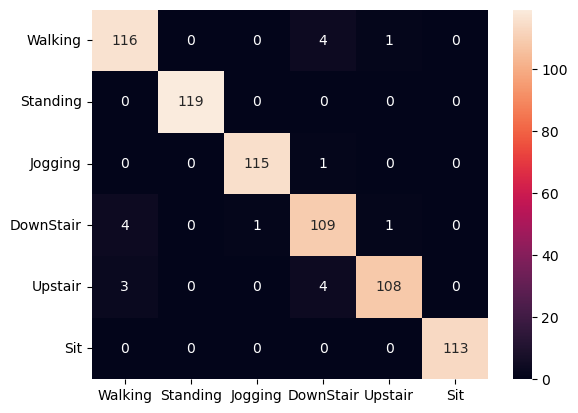

In [90]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=1 , max_depth=6) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_index_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [92]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_index_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.94308943 1.         0.99137931 0.92372881 0.98181818 1.        ]
[0.95867769 1.         0.99137931 0.94782609 0.93913043 1.        ]
[0.95081967 1.         0.99137931 0.93562232 0.96       1.        ]
[121 119 116 115 115 113]


### test with SVM

<AxesSubplot:>

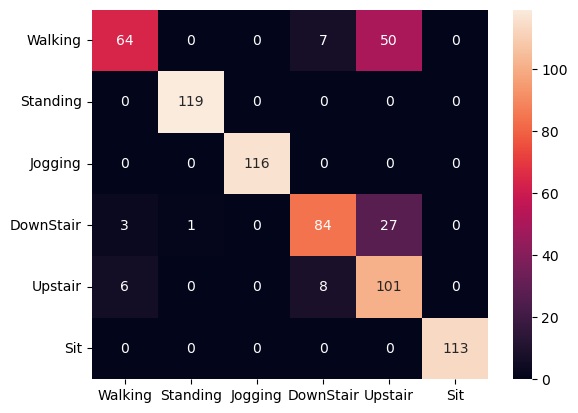

In [93]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = svm.SVC(kernel='rbf', degree=4) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_index_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [94]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_index_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.87671233 0.99166667 1.         0.84848485 0.56741573 1.        ]
[0.52892562 1.         1.         0.73043478 0.87826087 1.        ]
[0.65979381 0.9958159  1.         0.78504673 0.6894198  1.        ]
[121 119 116 115 115 113]
